In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNetCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
data = pd.read_sql_query('select * from houseprices', con=engine)
engine.dispose()

In [3]:
# Overview of data
display(data.head())
print('Data dimensions'.center(50, '-'))
print('\n' + 'Row count: {}\nColumn count: {}'.format(data.shape[0], data.shape[1]))
print('\n' + 'Data information'.center(50, '-'))
display(data.info())

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


-----------------Data dimensions------------------

Row count: 1460
Column count: 81

-----------------Data information-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bld

None

In [4]:
# Null Value Analysis
print('\n' + 'Null Value Analysis:'.center(50,'-') + '\n')
c_drop = []
for c, n in enumerate(data.isnull().sum()):
  if n > 0:
    print(data.isnull().sum().index[c] + ': ' + str(round(n/1460 *100,2)) + '%')
    c_drop.append(data.isnull().sum().index[c])

# Drop all columns with null values except electrical since it's only missing one. We will drop that one row instead to keep electrical as a variable.
c_drop.pop(c_drop.index('electrical'))
cdata = data.drop(c_drop, axis=1)
cdata = cdata.dropna()


---------------Null Value Analysis:---------------

lotfrontage: 17.74%
alley: 93.77%
masvnrtype: 0.55%
masvnrarea: 0.55%
bsmtqual: 2.53%
bsmtcond: 2.53%
bsmtexposure: 2.6%
bsmtfintype1: 2.53%
bsmtfintype2: 2.6%
electrical: 0.07%
fireplacequ: 47.26%
garagetype: 5.55%
garageyrblt: 5.55%
garagefinish: 5.55%
garagequal: 5.55%
garagecond: 5.55%
poolqc: 99.52%
fence: 80.75%
miscfeature: 96.3%


In [6]:
# Numerical and Categorical data analysis
print('Numerical Stats:'.center(50,'-') + '\n')
display(cdata.describe())
print('\n' + 'Categorical Stats:'.center(50,'-'))
display(cdata.describe(include='object'))

-----------------Numerical Stats:-----------------



,id,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,730.054832,56.881426,10517.363948,6.100069,5.575737,1971.244003,1984.850583,443.943797,46.581220,567.366004,...,94.240576,46.692255,21.969157,3.411926,15.071282,2.760795,43.518849,6.322824,2007.815627,180930.394791
std,421.411181,42.310746,9984.666267,1.383171,1.113079,30.199555,20.644343,456.106417,161.369977,441.992392,...,125.381679,66.267472,61.137400,29.327247,55.775138,40.191018,496.291826,2.704331,1.328542,79468.964025
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.500000,20.000000,7549.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129950.000000
50%,730.000000,50.000000,9477.000000,6.000000,5.000000,1973.000000,1994.000000,384.000000,0.000000,479.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1094.500000,70.000000,11603.000000,7.000000,6.000000,2000.000000,2004.000000,712.500000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000



----------------Categorical Stats:----------------


,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,...,foundation,heating,heatingqc,centralair,electrical,kitchenqual,functional,paveddrive,saletype,salecondition
count,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,...,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459
unique,5,2,4,4,2,5,3,25,9,8,...,6,6,5,2,5,4,7,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,PConc,GasA,Ex,Y,SBrkr,TA,Typ,Y,WD,Normal
freq,1150,1453,924,1310,1458,1051,1381,225,1259,1444,...,646,1427,741,1364,1334,735,1359,1339,1266,1197


Text(0.5, 1.0, 'House Prices')

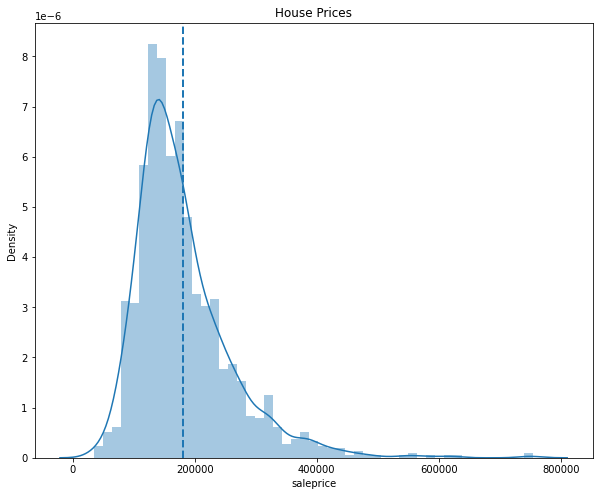

In [9]:
# Histogram of house prices
plt.figure(figsize=(10,8))
sns.distplot(cdata['saleprice'])
plt.axvline(x=cdata['saleprice'].mean(), linestyle='--', linewidth=2)
plt.title('House Prices')

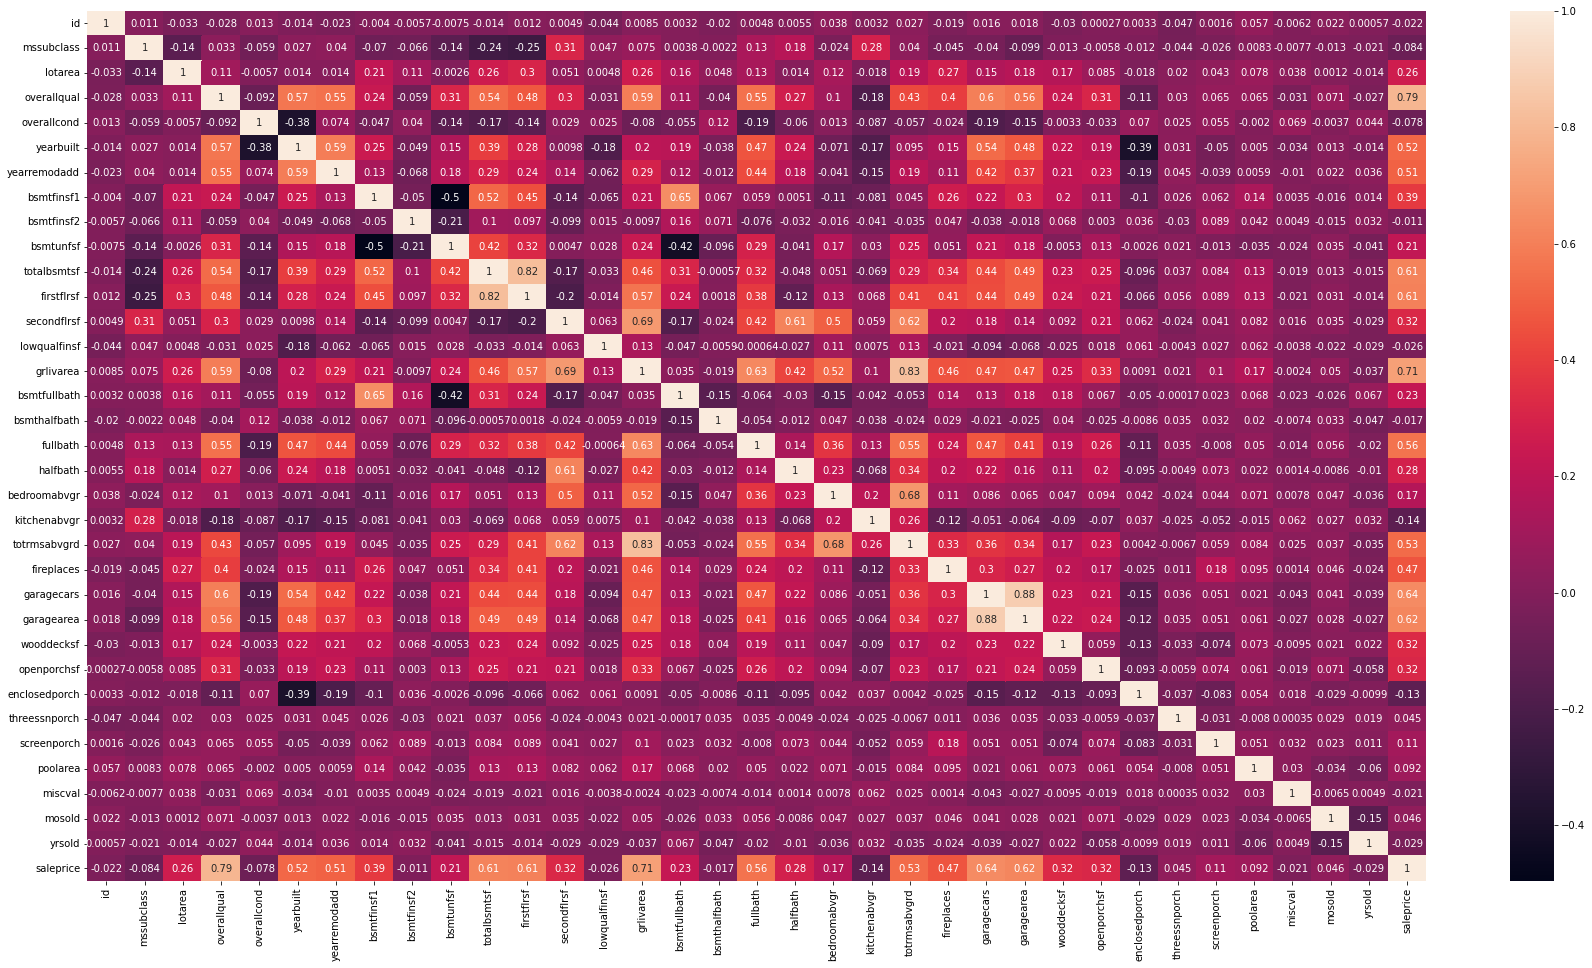

In [11]:
# Correlation heat map to eliminate some variables
num_cols = cdata.select_dtypes(include='number').index
plt.figure(figsize=(30, 16))
sns.heatmap(cdata.corr(), annot=True)

In [12]:
# Choose features that correlate with saleprice > 0.1 or <-0.1
corr = cdata.corr()['saleprice']
pdata = cdata[corr[(corr >= 0.1) | (corr <= -0.1)].index]
pdata.head()

,lotarea,overallqual,yearbuilt,yearremodadd,bsmtfinsf1,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,grlivarea,...,kitchenabvgr,totrmsabvgrd,fireplaces,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,screenporch,saleprice
0,8450,7,2003,2003,706,150,856,856,854,1710,...,1,8,0,2,548,0,61,0,0,208500
1,9600,6,1976,1976,978,284,1262,1262,0,1262,...,1,6,1,2,460,298,0,0,0,181500
2,11250,7,2001,2002,486,434,920,920,866,1786,...,1,6,1,2,608,0,42,0,0,223500
3,9550,7,1915,1970,216,540,756,961,756,1717,...,1,7,1,3,642,0,35,272,0,140000
4,14260,8,2000,2000,655,490,1145,1145,1053,2198,...,1,9,1,3,836,192,84,0,0,250000


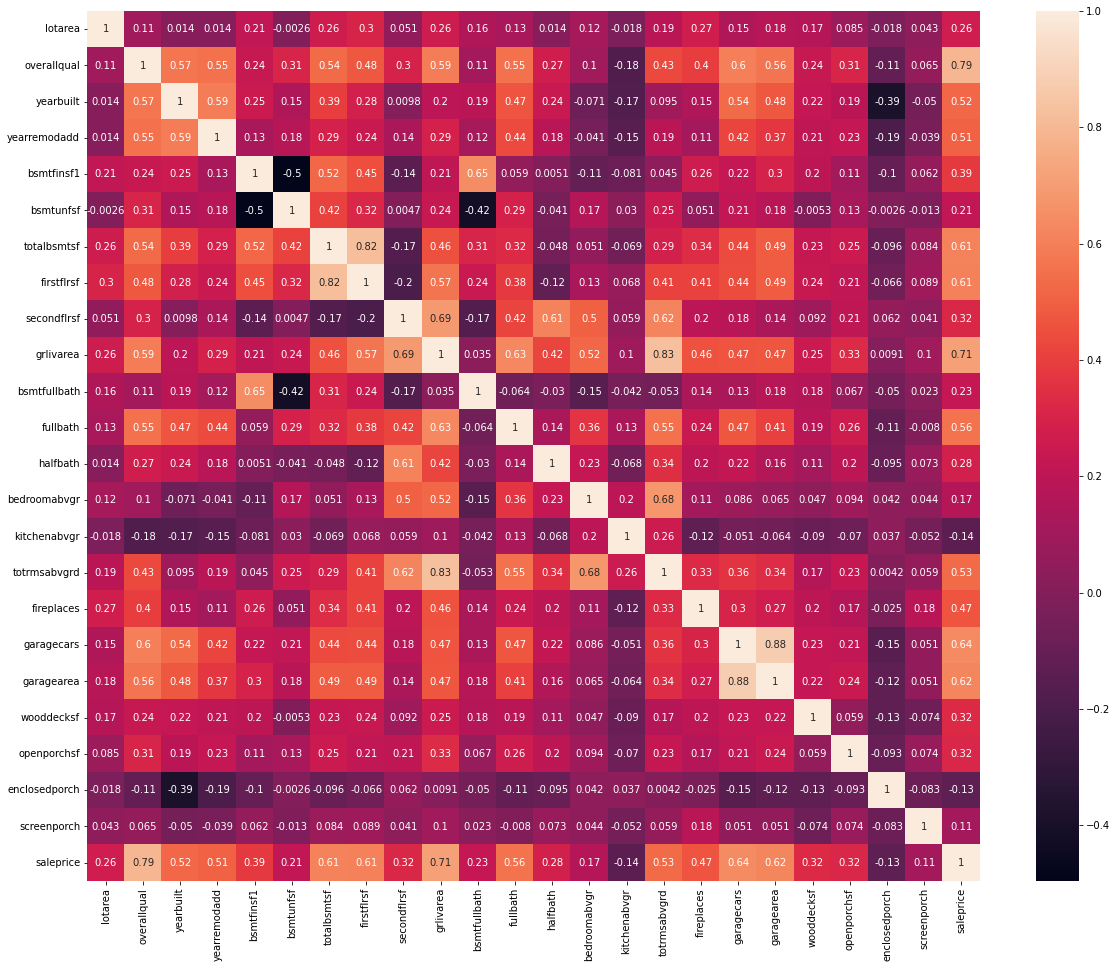

In [28]:
plt.figure(figsize=(20, 16))
sns.heatmap(pdata.corr(), annot=True)

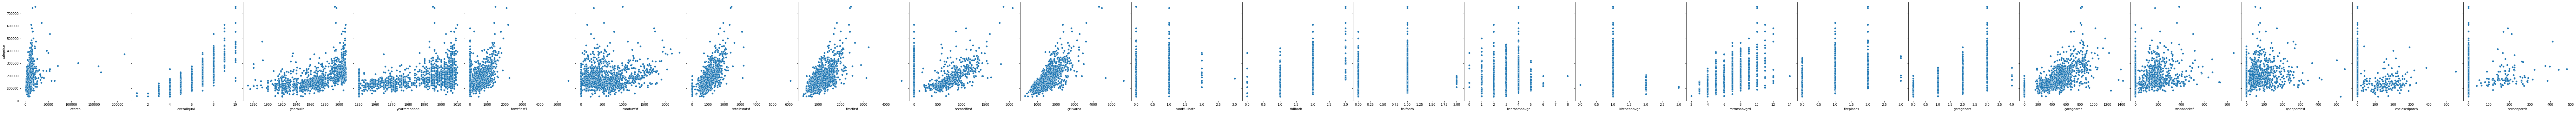

In [13]:
# Visualize relationships with pairplots
sns.pairplot(data=pdata, height=5, x_vars=pdata.columns[pdata.columns != 'saleprice'], y_vars=['saleprice'])

In [15]:
# Seperate data
Y = pdata['saleprice']
X = pdata[pdata.columns[pdata.columns != 'saleprice']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=20)

In [16]:
# Create and evaluate a simple linear regression model to predict housing prices based on the selected features.
lr = LinearRegression().fit(X_train, y_train)
lrtr_preds = lr.predict(X_train)
lrte_preds = lr.predict(X_test)

print('R-squared for training set: {}'.format(lr.score(X_train, y_train)))
print('R-squared for test set: {}'.format(lr.score(X_test, y_test)))
print('Mean absolute error: {}'.format(mae(y_test, lrte_preds)))
print('Mean squared error: {}'.format(mse(y_test, lrte_preds)))
print('Root mean squared error: {}'.format(rmse(y_test, lrte_preds)))

R-squared for training set: 0.7900817296689565
R-squared for test set: 0.823338399559397
Mean absolute error: 21813.15180379759
Mean squared error: 1036433793.704082
Root mean squared error: 32193.691830917465


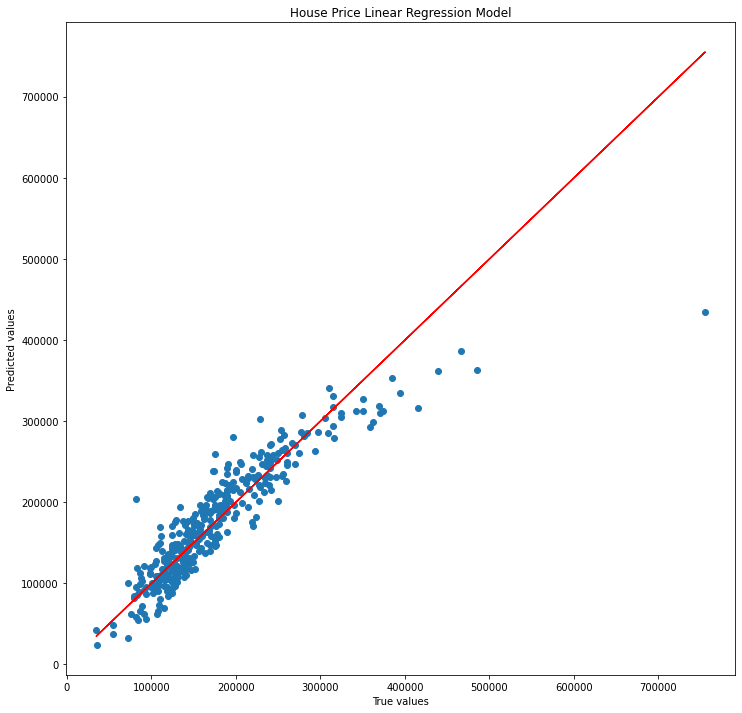

In [31]:
# Visualize the model
plt.figure(figsize=(12,12))
plt.scatter(y_test, lrte_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("House Price Linear Regression Model")
plt.show()

In [17]:
# Create Ridge regression model
ridge = RidgeCV([0.5, 10, 10**37], cv=10).fit(X_train, y_train)
rtr_preds = ridge.predict(X_train)
rte_preds = ridge.predict(X_test)

print('R-squared for training set: {}'.format(ridge.score(X_train, y_train)))
print('R-squared for test set: {}'.format(ridge.score(X_test, y_test)))
print('Mean absolute error: {}'.format(mae(y_test, rte_preds)))
print('Mean squared error: {}'.format(mse(y_test, rte_preds)))
print('Root mean squared error: {}'.format(rmse(y_test, rte_preds)))

R-squared for training set: 0.7898783310470269
R-squared for test set: 0.8239173493742683
Mean absolute error: 21792.60328297068
Mean squared error: 1033037225.6242349
Root mean squared error: 32140.896465783822


In [36]:
# First model performed pretty well, but let's see if we can improve it by accounting for collinearity and further shrinking less relevant variables.
# Create Elastic Net regression model.
en = ElasticNetCV(l1_ratio=0.4, alphas=[0.3, 0.4, 0.5], cv=10).fit(X_train, y_train)
entr_preds = en.predict(X_train)
ente_preds = en.predict(X_test)

print('R-squared for training set: {}'.format(en.score(X_train, y_train)))
print('R-squared for test set: {}'.format(en.score(X_test, y_test)))
print('Mean absolute error: {}'.format(mae(y_test, ente_preds)))
print('Mean squared error: {}'.format(mse(y_test, ente_preds)))
print('Root mean squared error: {}'.format(rmse(y_test, ente_preds)))

R-squared for training set: 0.7839212715119852
R-squared for test set: 0.8261124530706333
Mean absolute error: 21272.458167595327
Mean squared error: 1020159046.9712436
Root mean squared error: 31939.928725206068


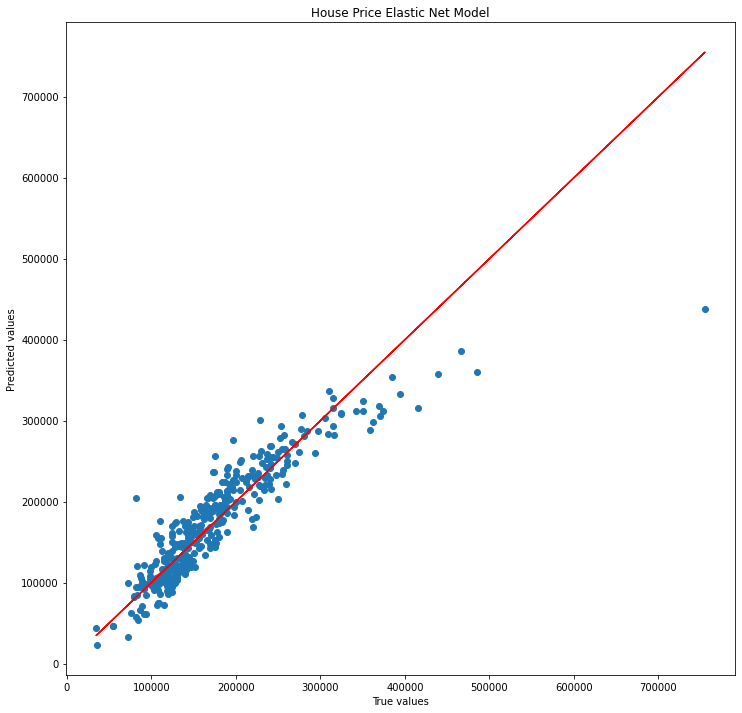

In [32]:
# Visualize the model
plt.figure(figsize=(12,12))
plt.scatter(y_test, ente_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("House Price Elastic Net Model")
plt.show()

In [19]:
# Marginal improvements were made with an epsilon of 0.3 across most measurements
# Since I took the time to pick relevant variables, let's test different l1 ratios.
for ratio in np.arange(0.1,1,0.1):
  en = ElasticNetCV(l1_ratio=ratio, alphas=[0.3, 0.4, 0.5], cv=10).fit(X_train, y_train)
  entr_preds = en.predict(X_train)
  ente_preds = en.predict(X_test)

  print('Ratio: {}'.format(ratio).center(50,'-'))
  print('R-squared for training set: {}'.format(en.score(X_train, y_train)))
  print('R-squared for test set: {}'.format(en.score(X_test, y_test)))
  print('Mean absolute error: {}'.format(mae(y_test, ente_preds)))
  print('Mean squared error: {}'.format(mse(y_test, ente_preds)))
  print('Root mean squared error: {}'.format(rmse(y_test, ente_preds)) + '\n')

--------------------Ratio: 0.1--------------------
R-squared for training set: 0.7811317121955217
R-squared for test set: 0.8257574598973982
Mean absolute error: 21125.41347272774
Mean squared error: 1022241711.9100723
Root mean squared error: 31972.514945028524

--------------------Ratio: 0.2--------------------
R-squared for training set: 0.7820498164961229
R-squared for test set: 0.8259496713986816
Mean absolute error: 21168.6457331447
Mean squared error: 1021114050.3527688
Root mean squared error: 31954.87522042245

------------Ratio: 0.30000000000000004------------
R-squared for training set: 0.7829799790417236
R-squared for test set: 0.8260731812018497
Mean absolute error: 21217.288878219188
Mean squared error: 1020389446.1742836
Root mean squared error: 31943.53527983845

--------------------Ratio: 0.4--------------------
R-squared for training set: 0.7839212715119852
R-squared for test set: 0.8261124530706333
Mean absolute error: 21272.458167595327
Mean squared error: 102015904

Looks like an L1 ratio of 0.4 provides the best performance, which makes sense since I took the time to reduce the amount of features in the dataset. It follows that a lower L1 ratio would probably yield better results assuming, since L1 regularization shrinks the absolute value of coefficients, which can even result in the dropping of less relevant features. Since we chose relatively high relevant features, this was unlikely to result in any improvement.

In [26]:
# Create random forest regressor model.
rf = RandomForestRegressor().fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print('R-squared for training set: {}'.format(rf.score(X_train, y_train)))
print('R-squared for test set: {}'.format(rf.score(X_test, y_test)))
print('Mean absolute error: {}'.format(mae(y_test, rf_preds)))
print('Mean squared error: {}'.format(mse(y_test, rf_preds)))
print('Root mean squared error: {}'.format(rmse(y_test, rf_preds)))

R-squared for training set: 0.9772554231796863
R-squared for test set: 0.8958363692626693
Mean absolute error: 17028.20205479452
Mean squared error: 611104545.0840951
Root mean squared error: 24720.528818860148


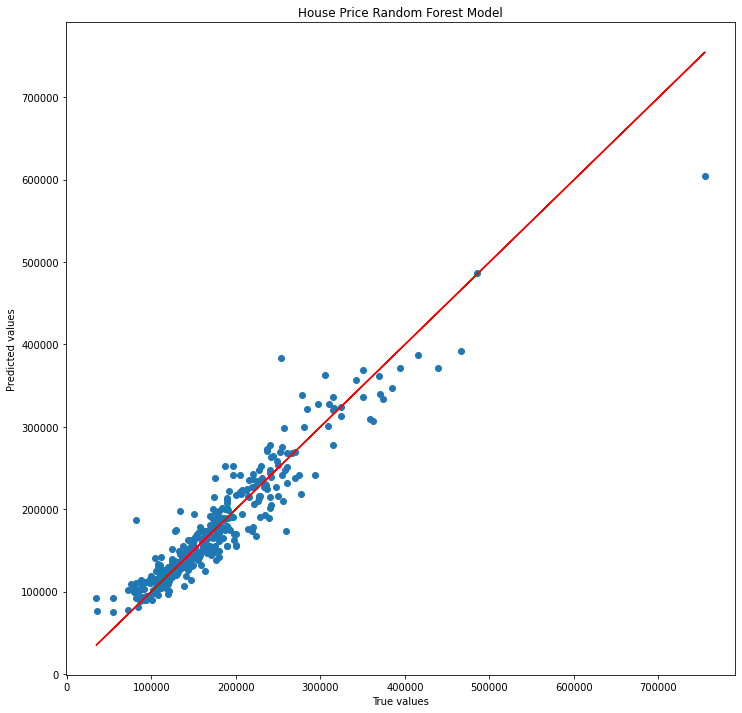

In [34]:
# Visualize the model
plt.figure(figsize=(12,12))
plt.scatter(y_test, rf_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("House Price Random Forest Model")
plt.show()

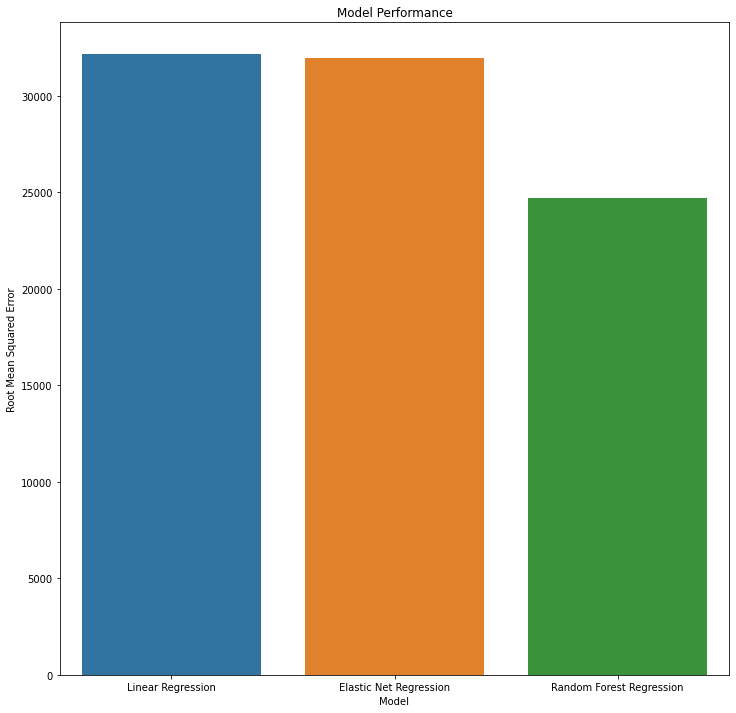

In [37]:
rmse = [rmse(y_test, lrte_preds),rmse(y_test, ente_preds),rmse(y_test, rf_preds)]
labels = ['Linear Regression', 'Elastic Net Regression', 'Random Forest Regression']

plt.figure(figsize=(12,12))
plt.title('Model Performance')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Model')
sns.barplot(x=labels, y=rmse)



---



---



In [ ]:
# I was recommended to increase the correlation threshold I used to select features as it is customary to use an R of >= 0.5.
# Select new features based on R = 0.5 and run models again.
ndata = cdata[corr[(corr >= 0.5) | (corr <= -0.5)].index]

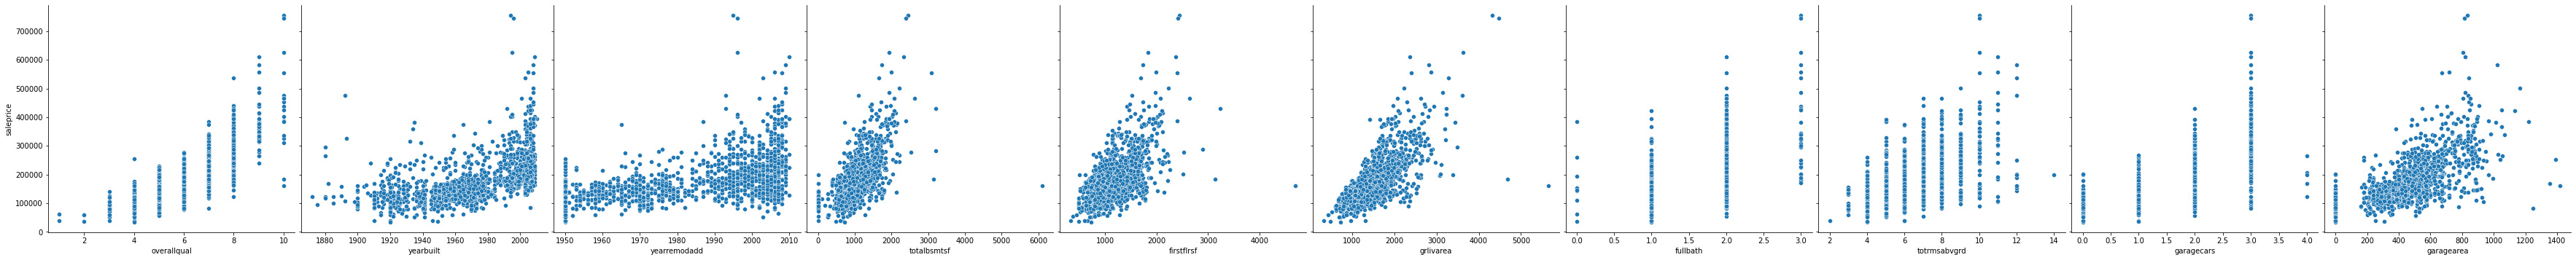

In [ ]:
# Visualize relationships with pairplots
sns.pairplot(data=ndata, height=5, x_vars=ndata.columns[ndata.columns != 'saleprice'], y_vars=['saleprice'])

In [ ]:
# Seperate data
Y = ndata['saleprice']
X = ndata[ndata.columns[ndata.columns != 'saleprice']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=2)

In [ ]:
# Create and evaluate a simple linear regression model to predict housing prices based on the selected features.
lr = LinearRegression().fit(X_train, y_train)
lrtr_preds = lr.predict(X_train)
lrte_preds = lr.predict(X_test)

print('R-squared for training set: {}'.format(lr.score(X_train, y_train)))
print('R-squared for test set: {}'.format(lr.score(X_test, y_test)))
print('Mean absolute error: {}'.format(mae(y_test, lrte_preds)))
print('Mean squared error: {}'.format(mse(y_test, lrte_preds)))
print('Root mean squared error: {}'.format(rmse(y_test, lrte_preds)))

R-squared for training set: 0.77874907162507
R-squared for test set: 0.7430611803478135
Mean absolute error: 22174.4386117459
Mean squared error: 1198841765.4002113
Root mean squared error: 34624.29443902375


In [ ]:
# First model performed pretty well, but let's see if we can improve it by accounting for collinearity and further shrinking less relevant variables.
# Create Elastic Net regression model.
en = ElasticNetCV(l1_ratio=0.5, alphas=[0.3, 0.4, 0.5], cv=10).fit(X_train, y_train)
entr_preds = en.predict(X_train)
ente_preds = en.predict(X_test)

print('R-squared for training set: {}'.format(en.score(X_train, y_train)))
print('R-squared for test set: {}'.format(en.score(X_test, y_test)))
print('Mean absolute error: {}'.format(mae(y_test, ente_preds)))
print('Mean squared error: {}'.format(mse(y_test, ente_preds)))
print('Root mean squared error: {}'.format(rmse(y_test, ente_preds)))

R-squared for training set: 0.776363447016751
R-squared for test set: 0.7433447017683226
Mean absolute error: 21900.80643084842
Mean squared error: 1197518892.816178
Root mean squared error: 34605.18592373371


In [ ]:
# Marginal improvements were made with an epsilon of 0.3 across most measurements
# Since I took the time to pick relevant variables, let's test different l1 ratios.
for ratio in np.arange(0.1,1.1,0.1):
  en = ElasticNetCV(l1_ratio=ratio, alphas=[0.3, 0.4, 0.5], cv=10).fit(X_train, y_train)
  entr_preds = en.predict(X_train)
  ente_preds = en.predict(X_test)

  print('Ratio: {}'.format(ratio).center(50,'-'))
  print('R-squared for training set: {}'.format(en.score(X_train, y_train)))
  print('R-squared for test set: {}'.format(en.score(X_test, y_test)))
  print('Mean absolute error: {}'.format(mae(y_test, ente_preds)))
  print('Mean squared error: {}'.format(mse(y_test, ente_preds)))
  print('Root mean squared error: {}'.format(rmse(y_test, ente_preds)) + '\n')

--------------------Ratio: 0.1--------------------
R-squared for training set: 0.7739350742151487
R-squared for test set: 0.7403282656136425
Mean absolute error: 21991.10212807592
Mean squared error: 1211593175.75166
Root mean squared error: 34807.94702006512

--------------------Ratio: 0.2--------------------
R-squared for training set: 0.7745421001083671
R-squared for test set: 0.7411368969187278
Mean absolute error: 21961.189390050662
Mean squared error: 1207820211.5002537
Root mean squared error: 34753.70788132187

------------Ratio: 0.30000000000000004------------
R-squared for training set: 0.7751512415307198
R-squared for test set: 0.7419204865562086
Mean absolute error: 21936.13125372394
Mean squared error: 1204164088.2814329
Root mean squared error: 34701.067538066214

--------------------Ratio: 0.4--------------------
R-squared for training set: 0.775759633623223
R-squared for test set: 0.7426638092927154
Mean absolute error: 21915.033304905388
Mean squared error: 1200695844.

Looks like an L1 ratio of 0.9 provided the best performance, is interesting since it doesn't follow the earlier pattern. This inidcates that the model was mainly using the L1 penalization function. This model also performed worse than the last one across all measures.